In [56]:
import glob
import itertools
import json
import os
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import requests
import seaborn as sns

sns.set('talk')

In [57]:
# waypointを補正したdataset
root_dir = Path('../../input/')
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
sub_df = pd.read_csv(root_dir / 'sample_submission.csv')

In [58]:

from tqdm.notebook import tqdm


def get_ground_truth(args):
    (collectionName, phoneName), df = args
    
    path = root_dir / f"train/{collectionName}/{phoneName}/ground_truth.csv"
    target_df = pd.read_csv(path)
    output_df = pd.DataFrame()
    # merge derived and target by 'millisSinceGpsEpoch'
    for epoch, epoch_df in df.groupby('millisSinceGpsEpoch'):
        idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
        epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
        epoch_df['epoch_diff'] = epoch_diff
        epoch_df['target_latDeg'] = target_df.loc[idx, 'latDeg']
        epoch_df['target_lngDeg'] = target_df.loc[idx, 'lngDeg']
        output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df


# metric
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [59]:
import multiprocessing

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(['collectionName','phoneName'])
    dfs = pool.imap_unordered(get_ground_truth, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

  0%|          | 0/73 [00:00<?, ?it/s]

In [60]:
train_df['distance'] = calc_haversine(train_df['latDeg'],train_df['lngDeg'],
                                      train_df['target_latDeg'], train_df['target_lngDeg'])

In [61]:
train_df['phone'] = train_df['collectionName'] + '-' + train_df['phoneName']
train_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg,distance
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,3.586842
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,2.745901
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,1.888409
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,1.213483
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,1.650722
...,...,...,...,...,...,...,...,...,...,...,...
2365,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2-SamsungS20Ultra,0,37.334475,-121.899613,2.052491
2366,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2-SamsungS20Ultra,0,37.334475,-121.899613,2.671673
2367,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2-SamsungS20Ultra,0,37.334475,-121.899613,2.287458
2368,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2-SamsungS20Ultra,0,37.334475,-121.899613,3.454306


Text(0.5, 0, 'error(m)')

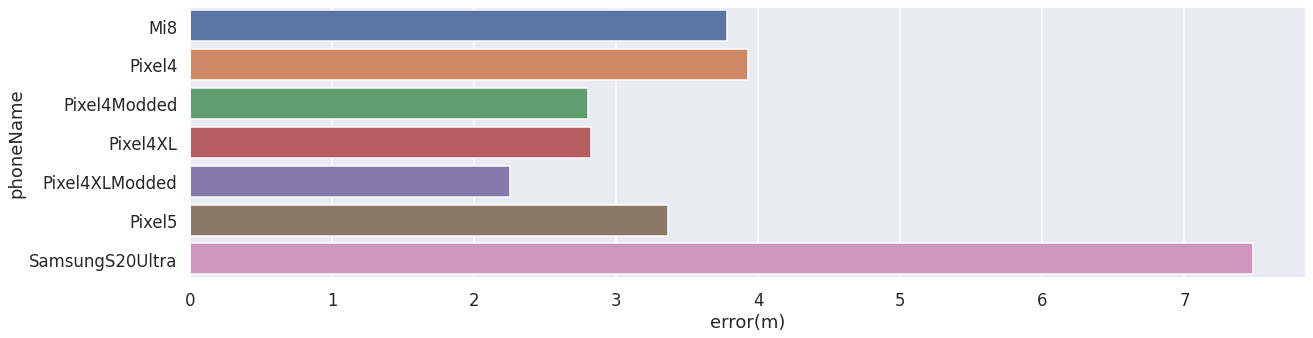

In [62]:
col = 'phoneName'
x = train_df.groupby([col])['distance'].mean().values
y = train_df.groupby([col])['distance'].mean().index

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
sns.barplot(x,y, ax=ax)
ax.set_ylabel(col)
ax.set_xlabel('error(m)')

Text(0.5, 0, 'error(m)')

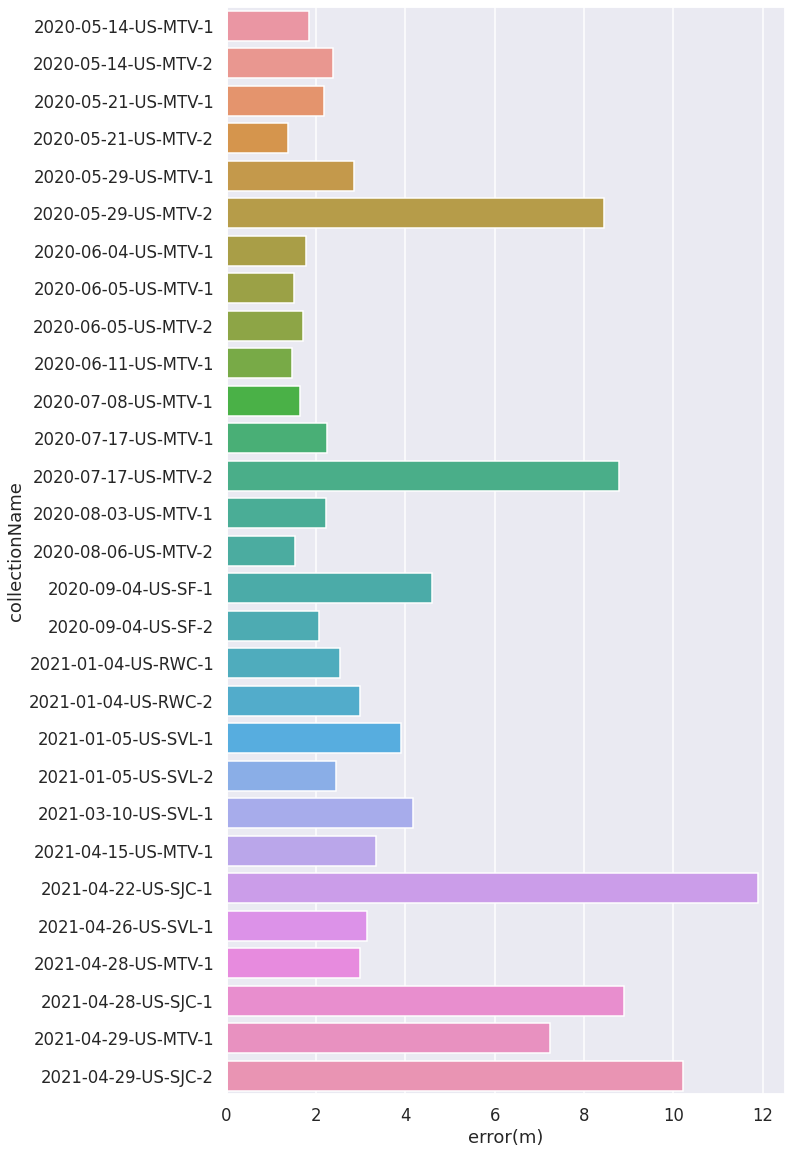

In [63]:
col = 'collectionName'
x = train_df.groupby([col])['distance'].mean().values
y = train_df.groupby([col])['distance'].mean().index

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot()
sns.barplot(x,y, ax=ax)
ax.set_ylabel(col)
ax.set_xlabel('error(m)')

Text(0.5, 0, 'error(m)')

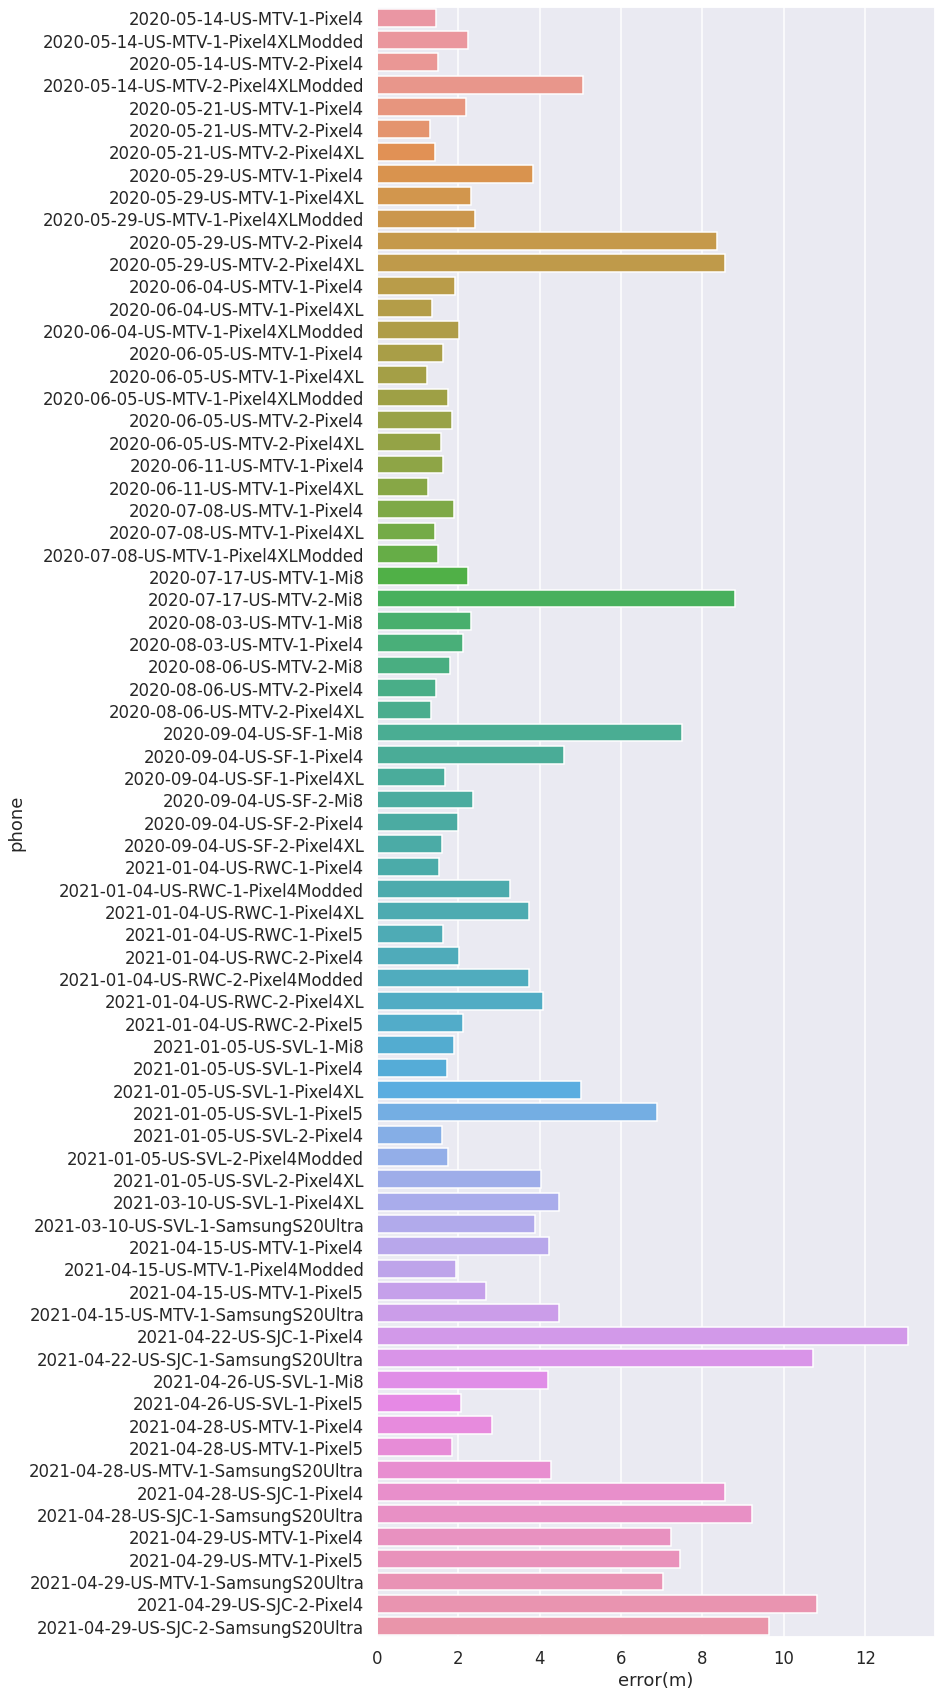

In [64]:
col = 'phone'
x = train_df.groupby([col])['distance'].mean().values
y = train_df.groupby([col])['distance'].mean().index

fig = plt.figure(figsize=(10,30))
ax = fig.add_subplot()
sns.barplot(x,y, ax=ax)
ax.set_ylabel(col)
ax.set_xlabel('error(m)')

In [81]:
train_df['site'] = train_df['collectionName'].str[11:].str.split('_', expand=True)[0]
train_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg,distance,site
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,3.586842,US-MTV-1
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,2.745901,US-MTV-1
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,1.888409,US-MTV-1
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,1.213483,US-MTV-1
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1-Pixel4,0,37.423576,-122.094132,1.650722,US-MTV-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2365,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2-SamsungS20Ultra,0,37.334475,-121.899613,2.052491,US-SJC-2
2366,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2-SamsungS20Ultra,0,37.334475,-121.899613,2.671673,US-SJC-2
2367,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2-SamsungS20Ultra,0,37.334475,-121.899613,2.287458,US-SJC-2
2368,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2-SamsungS20Ultra,0,37.334475,-121.899613,3.454306,US-SJC-2


Text(0.5, 0, 'error(m)')

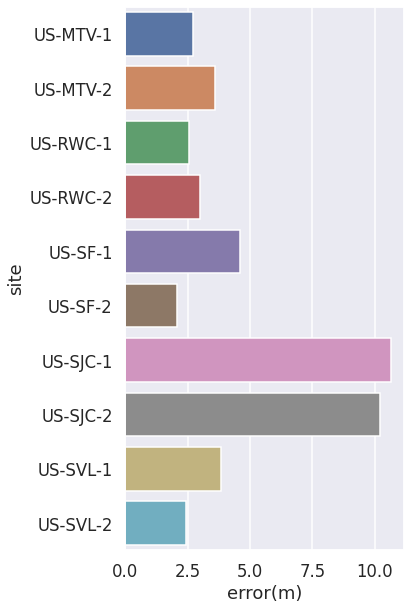

In [83]:
col = 'site'
x = train_df.groupby([col])['distance'].mean().values
y = train_df.groupby([col])['distance'].mean().index

fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot()
sns.barplot(x,y, ax=ax)
ax.set_ylabel(col)
ax.set_xlabel('error(m)')

In [65]:
sub_df['phone'].nunique()

48

In [66]:
sub_df['collectionName'] = sub_df['phone'].str.split('_', expand=True)[0]
sub_df['phoneName'] = sub_df['phone'].str.split('_', expand=True)[1]

In [67]:
sub_df['collectionName'].nunique(), sub_df['phoneName'].nunique()

(19, 7)

In [68]:
sub_df.groupby('collectionName')['phoneName'].nunique()

collectionName
2020-05-15-US-MTV-1    2
2020-05-28-US-MTV-1    2
2020-05-28-US-MTV-2    3
2020-06-04-US-MTV-2    3
2020-06-10-US-MTV-1    3
2020-06-10-US-MTV-2    3
2020-08-03-US-MTV-2    3
2020-08-13-US-MTV-1    2
2021-03-16-US-MTV-2    2
2021-03-16-US-RWC-2    3
2021-03-25-US-PAO-1    5
2021-04-02-US-SJC-1    2
2021-04-08-US-MTV-1    4
2021-04-21-US-MTV-1    2
2021-04-22-US-SJC-2    1
2021-04-26-US-SVL-2    1
2021-04-28-US-MTV-2    2
2021-04-29-US-MTV-2    3
2021-04-29-US-SJC-3    2
Name: phoneName, dtype: int64

In [69]:
sub_df[sub_df['collectionName']=='2021-04-22-US-SJC-2']

,phone,millisSinceGpsEpoch,latDeg,lngDeg,collectionName,phoneName
74067,2021-04-22-US-SJC-2_SamsungS20Ultra,1303164074000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra
74068,2021-04-22-US-SJC-2_SamsungS20Ultra,1303164075000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra
74069,2021-04-22-US-SJC-2_SamsungS20Ultra,1303164076000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra
74070,2021-04-22-US-SJC-2_SamsungS20Ultra,1303164077000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra
74071,2021-04-22-US-SJC-2_SamsungS20Ultra,1303164078000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra
...,...,...,...,...,...,...
76386,2021-04-22-US-SJC-2_SamsungS20Ultra,1303166393000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra
76387,2021-04-22-US-SJC-2_SamsungS20Ultra,1303166394000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra
76388,2021-04-22-US-SJC-2_SamsungS20Ultra,1303166395000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra
76389,2021-04-22-US-SJC-2_SamsungS20Ultra,1303166396000,37.904611,-86.481078,2021-04-22-US-SJC-2,SamsungS20Ultra


In [70]:
sub_df[sub_df['collectionName']=='2021-04-26-US-SVL-2']

,phone,millisSinceGpsEpoch,latDeg,lngDeg,collectionName,phoneName
76391,2021-04-26-US-SVL-2_SamsungS20Ultra,1303515493000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra
76392,2021-04-26-US-SVL-2_SamsungS20Ultra,1303515494000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra
76393,2021-04-26-US-SVL-2_SamsungS20Ultra,1303515495000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra
76394,2021-04-26-US-SVL-2_SamsungS20Ultra,1303515496000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra
76395,2021-04-26-US-SVL-2_SamsungS20Ultra,1303515497000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra
...,...,...,...,...,...,...
78710,2021-04-26-US-SVL-2_SamsungS20Ultra,1303517812000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra
78711,2021-04-26-US-SVL-2_SamsungS20Ultra,1303517813000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra
78712,2021-04-26-US-SVL-2_SamsungS20Ultra,1303517814000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra
78713,2021-04-26-US-SVL-2_SamsungS20Ultra,1303517815000,37.904611,-86.481078,2021-04-26-US-SVL-2,SamsungS20Ultra


0        US-MTV-1
1        US-MTV-1
2        US-MTV-1
3        US-MTV-1
4        US-MTV-1
           ...   
91481    US-SJC-3
91482    US-SJC-3
91483    US-SJC-3
91484    US-SJC-3
91485    US-SJC-3
Name: 0, Length: 91486, dtype: object